# Building the simplest Graph

We start with a graph with two nodes connected by one edge.


In [ ]:
!pip install  -qU langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 1.8 MB/s eta 0:00:00


Nodes act like functions that can be called as needed. In our case Node 1 is our starting point and Node 2 is our finish point.

# **Nodes**
Nodes are just python functions.


In [ ]:
def function_1(input_1):
    return input_1 + " I am "

def function_2(input_2):
    return input_2 + "happy"

# **Edges**
Edges connect the nodes.

Normal Edges are used if you want to always go from, for example, node_1 to node_2.

In [ ]:
from langgraph.graph import Graph, START, END

# Define a graph
workflow = Graph()

# define nodes
workflow.add_node("node_1", function_1)
workflow.add_node("node_2", function_2)

# define edges
workflow.add_edge(START, 'node_1')
workflow.add_edge('node_1', 'node_2')
workflow.add_edge('node_2', END)

graph = workflow.compile()

In [ ]:
print(graph)
print(type(graph))

<class 'langgraph.graph.graph.CompiledGraph'>


In [ ]:
print(graph.get_graph())

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=<class 'langgraph.graph.graph.LangGraphInput'>, metadata=None), 'node_1': Node(id='node_1', name='node_1', data=node_1(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'node_2': Node(id='node_2', name='node_2', data=node_2(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=<class 'langgraph.graph.graph.LangGraphOutput'>, metadata=None)}, edges=[Edge(source='__start__', target='node_1', data=None, conditional=False), Edge(source='node_1', target='node_2', data=None, conditional=False), Edge(source='node_2', target='__end__', data=None, conditional=False)])


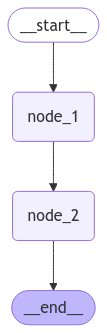

In [ ]:
from IPython.display import Image

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Executing a LangGraph: The Runnable Protocol

When a LangGraph is compiled, it **implements the Runnable Protocol**.  
This means it follows a **standardized way** of execution in LangChain.

### 🔹 What is the Runnable Protocol?
It defines methods to run LangChain components, including:
- `.invoke(input)`: Runs the component with an input and returns the result.
- `.stream(input)`: Streams the output in real-time.

### 🔹 Why is this important?
Since the compiled graph follows this protocol, we can execute it just like other LangChain components.

### 🔹 Example Usage
```python
output = graph.invoke(input)
print(output)


In [ ]:
graph.invoke("Hello")

'Hello I am happy'

**invoke** runs the entire graph synchronously.

This waits for each step to complete before moving to the next.

It returns the final state of the graph after all nodes have executed

In [ ]:
input = 'Hello'
for output in graph.stream(input):
    # print(output)

    for key,value in output.items():
      # print(item)
        print(f"Output from node '{key}':")
        print("---")
        print(value)

    print("\n---\n")

Output from node 'node_1':
---
Hello I am 

---

Output from node 'node_2':
---
Hello I am happy

---



### As you can see, we can run the nodes as functions and return some values from them.



# Adding LLM Call

Now, let's make the first node as an "Agent" that can call Open AI models. We can use langchain to make this call easy for us.

In [ ]:
!pip install -qU langchain langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.0 MB/s eta 0:00:00


In [ ]:
# access environment variables

from google.colab import userdata
gemini_api_key = userdata.get('GEMINI_API_KEY')

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

# Initialize an instance of the ChatGoogleGenerativeAI with specific parameters
model: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    # model="gemini-1.5-flash",  # Specify the model to use
    model="gemini-2.0-flash-exp",
    api_key=gemini_api_key    # Provide the Google API key for authentication
)

In [ ]:
#Call the model with a user message
response = model.invoke('Hey there')
response

AIMessage(content='Hey! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-74e384d8-125c-454e-9e0e-af005c02f70c-0', usage_metadata={'input_tokens': 2, 'output_tokens': 10, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [ ]:
response = model.invoke('Hey there')
response.content

'Hey! How can I help you today?'

Cool! Keeping that in mind, let's change the function 1 above so that we can send the user question to the model. Then we will send this response to function 2, which will add a short string and return to the user.

In [ ]:
def function_1(input_1):
    response = model.invoke(input_1)
    return response.content

def function_2(input_2):
    return "Agent Says: " + input_2

In [ ]:
from langgraph.graph import Graph, START, END

# Define a graph
workflow = Graph()

# define nodes
workflow.add_node("node_1", function_1)
workflow.add_node("node_2", function_2)

# define edges
workflow.add_edge(START, 'node_1')
workflow.add_edge('node_1', 'node_2')
workflow.add_edge('node_2', END)

graph = workflow.compile()

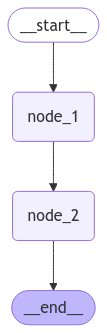

In [ ]:
from IPython.display import Image

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke("Hey there")

'Agent Says: Hey! How can I help you today?'

In [ ]:
# just a helpter function
import textwrap
from IPython.display import display, Markdown

def to_markdown(text)-> Markdown:
    text : str = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

In [ ]:
response  = graph.invoke("Motivate me to learn agentic ai")

# print(response)
to_markdown(response)

> Agent Says: Okay, let's get you fired up about learning Agentic AI! Here's a multi-pronged approach to motivate you, hitting on different aspects of the field and why it's worth your time:
> 
> **1. The "Future is Now" Argument:**
> 
> *   **Be at the Forefront:** Agentic AI is *the* next frontier in AI. It's moving beyond passive models that simply respond to prompts. This is about creating systems that can plan, act, learn, and adapt autonomously. You'll be learning a skill that's in high demand and will only become more crucial in the coming years.
> *   **Shape the Future:**  By learning Agentic AI, you're not just passively observing the future unfold, you're actively shaping it. You'll be equipped to build the tools and systems that will define how AI interacts with the world.
> *   **Early Adopter Advantage:**  The field is still relatively new. This means there's a huge opportunity to become a recognized expert, contribute to groundbreaking research, and build a strong career foundation.  Imagine being one of the first to truly understand and master this transformative technology!
> 
> **2. The "Problem Solver" Perspective:**
> 
> *   **Tackle Complex Challenges:**  Agentic AI is designed to solve problems that are too complex for traditional AI or human intervention alone. Think about optimizing supply chains, managing complex projects, conducting scientific research, or even creating personalized education experiences. You'll be working on real-world problems that have a significant impact.
> *   **Unlock New Possibilities:**  Agentic AI can automate tasks, free up human creativity, and accelerate progress in various fields. You'll be empowering others to achieve more and discover new possibilities.
> *   **Constantly Evolving:**  The field is dynamic and constantly evolving, which means you'll always be learning and pushing the boundaries of what's possible.  This intellectual stimulation can be incredibly rewarding.
> 
> **3. The "Career & Skillset" Angle:**
> 
> *   **High Demand, High Pay:**  The demand for skilled Agentic AI engineers, researchers, and developers is skyrocketing. This translates to excellent career prospects and competitive salaries.
> *   **Versatile Skillset:**  Learning Agentic AI involves a broad range of skills, including:
>     *   **AI/ML Fundamentals:**  Reinforcement learning, deep learning, natural language processing.
>     *   **Software Engineering:**  Python, frameworks like Langchain, AutoGPT, etc.
>     *   **System Design:**  Designing and building complex, autonomous systems.
>     *   **Problem-Solving:**  Critical thinking, analytical skills, and the ability to break down complex problems.
> *   **Career Paths:**  You could pursue roles like:
>     *   Agentic AI Engineer
>     *   AI Researcher
>     *   Robotics Engineer
>     *   Autonomous Systems Developer
>     *   AI Product Manager
> 
> **4. The "Let's Get Practical" Approach:**
> 
> *   **Start Small, Build Momentum:**  Don't feel overwhelmed. Start with the basics. Focus on learning Python, then dive into the fundamentals of reinforcement learning and NLP.
> *   **Hands-On Projects:**  The best way to learn is by doing. Build small projects that allow you to experiment with different Agentic AI concepts.  Examples:
>     *   A simple task completion agent using Langchain.
>     *   An agent that can navigate a virtual environment.
>     *   An agent that can summarize and extract information from documents.
> *   **Online Resources:**  There are tons of great resources available online:
>     *   **Courses:** Coursera, edX, Udacity, fast.ai
>     *   **Tutorials:** YouTube, Medium, Towards Data Science
>     *   **Communities:**  Discord servers, Reddit forums, GitHub repositories
> 
> **5. The "Inspiration & Awe" Factor:**
> 
> *   **Witness the Magic:**  Seeing an agent successfully complete a complex task autonomously is truly inspiring. It's like witnessing the birth of a new form of intelligence.
> *   **Imagine the Possibilities:**  Think about the potential impact of Agentic AI on healthcare, education, environmental sustainability, and countless other fields.  You could be a part of creating a better future for everyone.
> 
> **Actionable Steps to Get Started Right Now:**
> 
> 1.  **Choose a Learning Path:** Pick a course or tutorial series that aligns with your current skill level and interests.
> 2.  **Set a Realistic Goal:** Commit to spending a specific amount of time each week learning about Agentic AI. Even 30 minutes a day can make a difference.
> 3.  **Find a Community:** Join an online forum or Discord server to connect with other learners and experts.
> 4.  **Start a Project:**  Pick a simple project that you can complete in a few weeks. This will give you a tangible goal to work towards and help you solidify your understanding.
> 5.  **Celebrate Your Progress:** Acknowledge your achievements and reward yourself for reaching milestones.
> 
> **In short, learning Agentic AI is an investment in your future. It's a challenging but incredibly rewarding field that offers the opportunity to solve complex problems, shape the future of technology, and build a fulfilling career.  So, what are you waiting for?  Dive in and start exploring!**
> 
> Good luck, and let me know if you have any more questions! Let's build the future!

In [ ]:
input = 'Hey there'
for output in graph.stream(input):
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'node_1':
---
Hey! How can I help you today?

---

Output from node 'node_2':
---
Agent Says: Hey! How can I help you today?

---



# First functional Agent App - City Temperature

### Step 1: Parse the city mentioned
Let's extract the city that a user mentions in a query

In [ ]:
def function_1(input_1):
    complete_query = "Your task is to provide only the city name based on the user query. \
        Nothing more, just the city name mentioned. Following is the user query: " + input_1
    response = model.invoke(complete_query)
    return response.content

def function_2(input_2):
    return "Agent Says: " + input_2

In [ ]:
from langgraph.graph import Graph, START, END

# Define a graph
workflow = Graph()

# define nodes
workflow.add_node("node_1", function_1)
workflow.add_node("node_2", function_2)

# define edges
workflow.add_edge(START, 'node_1')
workflow.add_edge('node_1', 'node_2')
workflow.add_edge('node_2', END)

graph = workflow.compile()

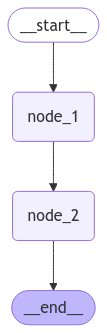

In [ ]:
from IPython.display import Image

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke("What's the temperature in Peshawar")

'Agent Says: Peshawar'

### Step 2: Adding a weather API call

What if we want the function 2 to take the city name and give us the weather for that city.

Well we know that Open Weather Map is [integrated](https://python.langchain.com/docs/integrations/tools/openweathermap) into LangChain

We need to install pyown, create an API key on the website of Open Weather Map (which takes a few hours to activate) and then run the cells below to get weather of a given city.

In [ ]:
!pip install -qU pyowm langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.4 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
openweathermap_api_key = userdata.get('OPENWEATHERMAP_API_KEY')

In [ ]:
from langchain_community.utilities import OpenWeatherMapAPIWrapper


weather = OpenWeatherMapAPIWrapper(openweathermap_api_key=openweathermap_api_key)

In [ ]:
weather_data = weather.run("London")
print(weather_data)

In London, the current weather is as follows:
Detailed status: overcast clouds
Wind speed: 5.66 m/s, direction: 70°
Humidity: 80%
Temperature: 
  - Current: 1.13°C
  - High: 2.06°C
  - Low: 0.03°C
  - Feels like: -3.85°C
Rain: {}
Heat index: None
Cloud cover: 90%


Now, let's integrate this into function 2 and call the function two as a "tool" or "weather_agent" instead of "node_2" in our workflow.

In [ ]:
def function_1(input_1):
    complete_query = "Your task is to provide only the city name based on the user query. \
        Nothing more, just the city name mentioned. Following is the user query: " + input_1
    response = model.invoke(complete_query)
    return response.content

def function_2(input_2):
    weather_data = weather.run(input_2)
    return weather_data

In [ ]:
from langgraph.graph import Graph, START, END

# Define a graph
workflow = Graph()

# define nodes
workflow.add_node("node_1", function_1)
workflow.add_node("weather_agent", function_2)

# define edges
workflow.add_edge(START, 'node_1')
workflow.add_edge('node_1', 'weather_agent')
workflow.add_edge('weather_agent', END)

graph = workflow.compile()

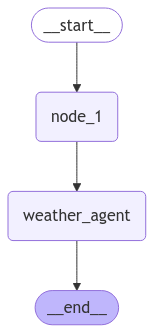

In [ ]:
from IPython.display import Image

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
to_markdown(graph.invoke("What's the temperature in Las Vegas"))

> In Las Vegas, the current weather is as follows:
> Detailed status: clear sky
> Wind speed: 3.6 m/s, direction: 40°
> Humidity: 27%
> Temperature: 
>   - Current: 17.22°C
>   - High: 18.4°C
>   - Low: 16.17°C
>   - Feels like: 15.7°C
> Rain: {}
> Heat index: None
> Cloud cover: 0%

In [ ]:
input = "What's the temperature in Las Vegas"
for output in graph.stream(input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'node_1':
---
Las Vegas

---

Output from node 'weather_agent':
---
In Las Vegas, the current weather is as follows:
Detailed status: clear sky
Wind speed: 3.6 m/s, direction: 40°
Humidity: 27%
Temperature: 
  - Current: 17.22°C
  - High: 18.4°C
  - Low: 16.17°C
  - Feels like: 15.7°C
Rain: {}
Heat index: None
Cloud cover: 0%

---



### Step 3 Adding another LLM Call to filter results

What if we only want the temperature? But current setup gives us the full weather report.

Well we can make another LLM call to filter data

In [ ]:
def function_3(input_3):
    complete_query = "Your task is to provide info concisely based on the user query. Following is the user query: " + "user input"
    response = model.invoke(complete_query)
    return response.content

But the issue is the user input is not available from node 2.

Can we pass user input all along from first node to the last?

Yes, we can use a dictionary and pass it between nodes (we could also use just a list, but dict makes it a bit easier)

In [ ]:
# assign AgentState as an empty dict
AgentState = {}

# messages key will be assigned as an empty array. We will append new messages as we pass along nodes.
AgentState["messages"] = []

In [ ]:
AgentState

{'messages': []}

Our goal is to have this state filled as:
{'messages': [HumanMessage, AIMessage, ...]]}

Also now we need to modify our functions to pass info along the new AgentState

In [ ]:
def function_1(state):
    messages = state['messages']
    user_input = messages[-1]
    complete_query = "Your task is to provide only the city name based on the user query. \
                    Nothing more, just the city name mentioned. Following is the user query: " + user_input
    response = model.invoke(complete_query)
    state['messages'].append(response.content) # appending AIMessage response to the AgentState
    return state

def function_2(state):
    messages = state['messages']
    agent_response = messages[-1]
    weather = OpenWeatherMapAPIWrapper(openweathermap_api_key=openweathermap_api_key)
    weather_data = weather.run(agent_response)
    state['messages'].append(weather_data)
    return state

def function_3(state):
    messages = state['messages']
    user_input = messages[0]
    available_info = messages[-1]
    agent2_query = "Your task is to provide info concisely based on the user query and the available information from the internet. \
                        Following is the user query: " + user_input + " Available information: " + available_info
    response = model.invoke(agent2_query)
    return response.content


In [ ]:
from langgraph.graph import Graph, START, END

# Define a graph
workflow = Graph()

# define nodes
workflow.add_node("agent", function_1)
workflow.add_node("tool", function_2)
workflow.add_node("responder",function_3)

# define edges
workflow.add_edge(START, 'agent')
workflow.add_edge('agent', 'tool')
workflow.add_edge('tool', 'responder')
workflow.add_edge('responder', END)

graph = workflow.compile()

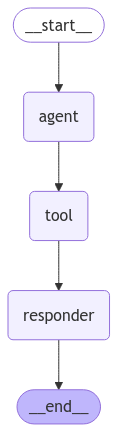

In [ ]:
from IPython.display import Image

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# graph.invoke("what is the temperature in Lahore")

In [ ]:
inputs = {"messages": ["what is the temperature in las vegas"]}
graph.invoke(inputs)

'The current temperature in Las Vegas is 17.22°C, but it feels like 15.7°C. The high for today is 18.4°C and the low is 16.17°C.'

In [ ]:
input = {"messages": ["what is the temperature in las vegas"]}
for output in graph.stream(input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
{'messages': ['what is the temperature in las vegas', 'Las Vegas']}

---

Output from node 'tool':
---
{'messages': ['what is the temperature in las vegas', 'Las Vegas', 'In Las Vegas, the current weather is as follows:\nDetailed status: clear sky\nWind speed: 3.6 m/s, direction: 40°\nHumidity: 27%\nTemperature: \n  - Current: 17.22°C\n  - High: 18.4°C\n  - Low: 16.17°C\n  - Feels like: 15.7°C\nRain: {}\nHeat index: None\nCloud cover: 0%']}

---

Output from node 'responder':
---
The current temperature in Las Vegas is 17.22°C, but it feels like 15.7°C. The high for today is 18.4°C and the low is 16.17°C.

---



# **State**
- First, define the State of the graph.

- The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the TypedDict class from python's typing module as our schema, which provides type hints for the keys.

As we notice that there is a lot of appending to the array going on, we can make it a bit easier with the following:

```bash
from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


It basically makes the state dictionary as saw previously, and also makes sure that any new message is appended to the messages array when we do the following:
```bash
{"messages": [new_array_element]}
```


##### We also realize that our app is not capable of answering simple questions like "how are you?"

In [ ]:
inputs = {"messages": ["hello"]}
graph.invoke(inputs)

NotFoundError: Unable to find the resource

This is because we always want to parse a city and then find the weather.

We can make our agent smarter by saying only use the tool when needed, if not just respond back to the user.

The way we can do this LangGraph is:
1. binding a tool to the agent
2. adding a conditional edge to the agent with the option to either call the tool or not
3. defining the criteria for the conditional edge as when to call the tool. We will define a function for this.


Let's start with the AgentState definition as mentioned a few cells above.

In [ ]:
from typing import TypedDict, Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


# Define a custom TypedDict that includes a list of messages with add_messages reducer
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Binding tool with agent (LLM Model) is made easy in langchain

In [ ]:
# access environment variables

from google.colab import userdata
gemini_api_key = userdata.get('GEMINI_API_KEY')

from google.colab import userdata
openweathermap_api_key = userdata.get('OPENWEATHERMAP_API_KEY')

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain_core.tools import tool

# Initialize an instance of the ChatGoogleGenerativeAI with specific parameters
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    # model="gemini-1.5-flash",  # Specify the model to use
    model="gemini-2.0-flash-exp",
    api_key=gemini_api_key    # Provide the Google API key for authentication
)


weather = OpenWeatherMapAPIWrapper(openweathermap_api_key=openweathermap_api_key)

@tool
def get_weather(city: str):
    """Get the current weather in a given city.

    Args:
        city: The city to get the weather for.

    Returns:
        The current weather in the given city.
    """
    return weather.run(city)

In [ ]:
tools = [get_weather]
llm_with_tool = llm.bind_tools(tools)

functional_call

In [ ]:
llm_with_tool.invoke("What is the temperature in Peshawar")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"city": "Peshawar"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-c18eb7f2-89f4-48b2-aba6-cdaaebba5c9e-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'Peshawar'}, 'id': 'a4f991f1-8cb3-4782-8a80-472c33df089a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 50, 'output_tokens': 6, 'total_tokens': 56, 'input_token_details': {'cache_read': 0}})

In [ ]:
llm_with_tool.invoke("Hello")

AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-2054b8bc-7d29-4fd4-98c0-ceb195aaf39e-0', usage_metadata={'input_tokens': 45, 'output_tokens': 10, 'total_tokens': 55, 'input_token_details': {'cache_read': 0}})

Our modified function_1 now becomes as below. The reason is, we are passing the human message as state and appending response to the state. Also, our agent now has a tool bound to it, that it can use.

In [ ]:
def function_1(state: AgentState):
    messages = state['messages']
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

Now make a tool node

In [ ]:
from langgraph.prebuilt import ToolNode

tools = [get_weather]

function_2 = ToolNode(tools)

Now with all of the changes above, our LangGraph app is modified as below:

In [ ]:
# from langgraph.graph import Graph, END

# workflow = Graph()

# Or you could import StateGraph and pass AgentState to it
from langgraph.graph import StateGraph, END, START
from langgraph.prebuilt import tools_condition
from langgraph.graph.state import CompiledStateGraph

workflow = StateGraph(AgentState)

workflow.add_node("agent", function_1)
workflow.add_node("tools", function_2)

# The conditional edge requires the following info below.
# First, we define the start node. We use `agent`.
# This means these are the edges taken after the `agent` node is called.
# Next, we pass in the function that will determine which node is called next, in our case where_to_go().

workflow.add_edge(START, 'agent')

# We now add a conditional edge from `agent` to `tool`.
workflow.add_conditional_edges(
                "agent",
                # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
                # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
                tools_condition
                )

# We now add a normal edge from `tools` to `agent`.
# This means that if `tool` is called, then it has to call the 'agent' next.
workflow.add_edge('tools', END)

# Basically, agent node has the option to call a tool node based on a condition,
# whereas tool node must call the agent in all cases based on this setup.


graph : CompiledStateGraph = workflow.compile()

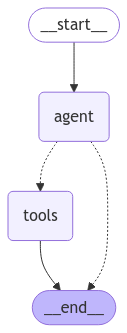

In [ ]:
from IPython.display import Image

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# # just another helpter function
# import textwrap
# from IPython.display import display, Markdown
# from langchain.schema import messages

# def to_markdown(state)-> Markdown:
#     # Extract the content of the last message
#     last_message = state['messages'][-1]

#     # If the message has a content attribute, use that, else handle gracefully
#     text = last_message.content

#     text = text.replace("•", "  *")
#     return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

We also pass the first message using HumanMessage component available in langchain, makes it easy to differentiate from AIMessage, and ToolMessage

In [ ]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="what is the temperature in Lahore")]}
# to_markdown(graph.invoke(inputs))
graph.invoke(inputs)

{'messages': [HumanMessage(content='what is the temperature in Lahore', additional_kwargs={}, response_metadata={}, id='0f6874fc-9093-40cb-ba51-e4379cd11dee'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"city": "Lahore"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-31ec645e-9d34-4c41-9eb1-1ce26083c8d1-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'Lahore'}, 'id': '2c3c2bda-56ad-4b44-9a46-c75c66e9cbd4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 50, 'output_tokens': 6, 'total_tokens': 56, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='In Lahore, the current weather is as follows:\nDetailed status: smoke\nWind speed: 0 m/s, direction: 0°\nHumidity: 63%\nTemperature: \n  - Current: 17.99°C\n  - High: 17.99°C\n  - Low: 17.99°C\n  - Feels like: 17.49°C\nRain: {}\nHeat index: None\nCloud cover: 20%',

In [ ]:
inputs = {"messages": [HumanMessage(content="what is the temperature in lahore")]}
for output in graph.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"city": "lahore"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-4491e8a7-8e26-41ae-994b-fe09f0b63fd0-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'lahore'}, 'id': '4e70e829-045b-487d-9447-330dd0501b49', 'type': 'tool_call'}], usage_metadata={'input_tokens': 51, 'output_tokens': 6, 'total_tokens': 57, 'input_token_details': {'cache_read': 0}})]}

---

Output from node 'tools':
---
{'messages': [ToolMessage(content='In lahore, the current weather is as follows:\nDetailed status: smoke\nWind speed: 0 m/s, direction: 0°\nHumidity: 63%\nTemperature: \n  - Current: 17.99°C\n  - High: 17.99°C\n  - Low: 17.99°C\n  - Feels like: 17.49°C\nRain: {}\nHeat index: None\nCloud cover: 20%', name='get_weather', id='b9e25acd-460d-416c-a30d-758bd2c82b4d', tool_

# Agent

## Review

We built a router.

* Our chat model will decide to make a tool call or not based upon the user input
* We use a conditional edge to route to a node that will call our tool or simply end

![Screenshot 2024-08-21 at 12.44.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0ba0bd34b541c448cc_agent1.png)

## Goals

Now, we can extend this into a generic agent architecture.

In the above router, we invoked the model and, if it chose to call a tool, we returned a `ToolMessage` to the user.

But, what if we simply pass that `ToolMessage` *back to the model*?

We can let it either (1) call another tool or (2) respond directly.

This is the intuition behind [ReAct](https://react-lm.github.io/), a general agent architecture.
  
* `act` - let the model call specific tools
* `observe` - pass the tool output back to the model
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

This [general purpose architecture](https://blog.langchain.dev/planning-for-agents/) can be applied to many types of tools.

![Screenshot 2024-08-21 at 12.45.43 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0b4a2c1e5e02f3e78b_agent2.png)

In [ ]:
from typing import TypedDict, Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage,AIMessage, HumanMessage, SystemMessage, ToolMessage
from langgraph.graph.message import add_messages


# Define a custom TypedDict that includes a list of messages with add_messages reducer
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

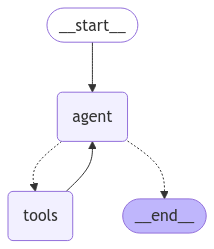

In [ ]:
# from langgraph.graph import Graph, END

# workflow = Graph()

# Or you could import StateGraph and pass AgentState to it
from langgraph.graph import StateGraph, END, START
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.state import CompiledStateGraph

workflow = StateGraph(AgentState)

tools = [get_weather]
workflow.add_node("agent", function_1)
workflow.add_node("tools", ToolNode(tools))

# The conditional edge requires the following info below.
# First, we define the start node. We use `agent`.
# This means these are the edges taken after the `agent` node is called.
# Next, we pass in the function that will determine which node is called next, in our case we are using prebuilt tools_condition by langgraph

workflow.add_edge(START, 'agent')

# We now add a conditional edge from `agent` to `tool`.
workflow.add_conditional_edges(
                "agent",
                # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
                # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
                tools_condition
                )

# We now add a normal edge from `tools` to `agent`.
# This means that if `tool` is called, then it has to call the 'agent' next.
workflow.add_edge('tools', "agent")

# Basically, agent node has the option to call a tool node based on a condition,
# whereas tool node must call the agent in all cases based on this setup.

react_graph : CompiledStateGraph = workflow.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
user_query = {"messages": [HumanMessage(content="what is the temperature in Lahore")]}
response = react_graph.invoke(user_query)
# to_markdown(response)

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is the temperature in Lahore
================================== Ai Message ==================================
Tool Calls:
  get_weather (02a4d11f-0b9e-4383-96bd-1aca204a5ecf)
 Call ID: 02a4d11f-0b9e-4383-96bd-1aca204a5ecf
  Args:
    city: Lahore
================================= Tool Message =================================
Name: get_weather

In Lahore, the current weather is as follows:
Detailed status: smoke
Wind speed: 0 m/s, direction: 0°
Humidity: 63%
Temperature: 
  - Current: 17.99°C
  - High: 17.99°C
  - Low: 17.99°C
  - Feels like: 17.49°C
Rain: {}
Heat index: None
Cloud cover: 20%
================================== Ai Message ==================================

The temperature in Lahore is currently 17.99°C, but it feels like 17.49°C. The high and low for today are both 17.99°C. The wind is calm at 0 m/s. The humidity is 63% and there is 20% cloud cover. The detailed status is smoke.


In [ ]:
user_query = {"messages": [HumanMessage(content="Hello I am Hammad and I built agents")]}
response = react_graph.invoke(user_query)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

Nice to meet you Hammad! How can I help you today?


In [ ]:
user_query = {"messages": [HumanMessage(content="Whats my name?")]}
response = react_graph.invoke(user_query)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

I do not have access to personal information. I cannot tell you your name.


We don't retain memory from our initial chat!

This limits our ability to have multi-turn conversations with interruptions.

We can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this!

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

```
  from langgraph.checkpoint.memory import MemorySaver
  memory = MemorySaver()
  react_graph_memory = builder.compile(checkpointer=memory)
```

# Agent memory

## Review

In previous steps, we built an agent that can:

* `act` - let the model call specific tools
* `observe` - pass the tool output back to the model
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

![Screenshot 2024-08-21 at 12.45.32 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab7453080e6802cd1703_agent-memory1.png)

## Goals

Now, we're going extend our agent by introducing memory.

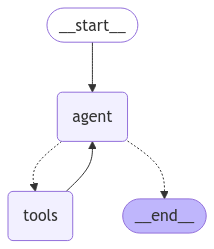

In [ ]:
# from langgraph.graph import Graph, END

# workflow = Graph()

# Or you could import StateGraph and pass AgentState to it
from langgraph.graph import StateGraph, END, START
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.state import CompiledStateGraph
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(AgentState)

tools = [get_weather]
workflow.add_node("agent", function_1)
workflow.add_node("tools", ToolNode(tools))

# The conditional edge requires the following info below.
# First, we define the start node. We use `agent`.
# This means these are the edges taken after the `agent` node is called.
# Next, we pass in the function that will determine which node is called next, in our case we are using prebuilt tools_condition by langgraph

workflow.add_edge(START, 'agent')

# We now add a conditional edge from `agent` to `tool`.
workflow.add_conditional_edges(
                "agent",
                # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
                # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
                tools_condition
                )

# We now add a normal edge from `tools` to `agent`.
# This means that if `tool` is called, then it has to call the 'agent' next.
workflow.add_edge('tools', "agent")

# Basically, agent node has the option to call a tool node based on a condition,
# whereas tool node must call the agent in all cases based on this setup.

memory = MemorySaver()
react_graph : CompiledStateGraph = workflow.compile(checkpointer=memory)

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread
* We can access that thread in the future using the `thread_id`

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)


**State Saving:** A checkpoint captures the current state of the graph, including the values of all variables, the state of all nodes, and the progress of the execution. This allows you to save the state at any point during the graph's execution

In [ ]:
# Thread
config = {"configurable": {"thread_id": "1"}}

In [ ]:
user_query = {"messages": [HumanMessage(content="Hello I am Hammad and I built agents")]}
response = react_graph.invoke(user_query,config)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

Nice to meet you Hammad! How can I help you today?


In [ ]:
user_query = {"messages": [HumanMessage(content="Whats my name?")]}
response = react_graph.invoke(user_query, config)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

Your name is Hammad.


In [ ]:
user_query = {"messages": [HumanMessage(content="What I do")]}
response = react_graph.invoke(user_query, config)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

You build agents.


In [ ]:
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    user_query = {"messages": [HumanMessage(content=user_input)]}
    response = react_graph.invoke(user_query, config)
    response["messages"][-1].pretty_print()
    print("\n")


  except:
    print("Invalid input. Please try again.")
    break

User: Hello
================================== Ai Message ==================================

Hello Hammad! How can I help you today?


User: Whats the temperature in Peshawar
================================== Ai Message ==================================

The temperature in Peshawar is currently 14.97°C, but it feels like 13.12°C.


User: thank you
================================== Ai Message ==================================

You're welcome! Is there anything else I can help you with?


User: exit
Goodbye!


Hopefully, that gives you a good understanding of how we built a LangGraph app and why we used different LC components.